# Brain Tumor Classification

In [7]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
# Import data managing libraries
import numpy as np
import pandas as pd

# Import Tensorflow
import tensorflow as tf
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import random
# Set the seed for repeatability
seed = 42

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python's built-in random module
random.seed(42)

In [9]:
from functions import process_data
import os

# Define data folder
data_folder = "data/"

# Define train, val, test folders
train_folder = os.path.join(data_folder, "Training/")
test_folder = os.path.join(data_folder, "Testing/")
val_folder = os.path.join(data_folder, "Validation/")

# Define our data directories
train_data_dir = train_folder
test_data_dir = test_folder
val_data_dir = val_folder

train_gen, test_gen, val_gen = process_data(256, 32, train_data_dir, test_data_dir, val_data_dir)

Found 2297 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [10]:
# Find out how the image data generators labeled our classes
train_class_labels = train_gen.class_indices
val_class_labels = train_gen.class_indices
test_class_labels = val_gen.class_indices

# Print the class labels
print("Train Class Labels:", train_class_labels)
print("Validation Class Labels:", val_class_labels)
print("Test Class Labels:", test_class_labels)

Train Class Labels: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Validation Class Labels: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Test Class Labels: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [11]:
# Retrieve one batch of data from the generator
data_batch, label_batch = next(train_gen)

# Print the shape of the data batch and label batch
print("Data batch shape:", data_batch.shape)
print("Label batch shape:", label_batch.shape)

Data batch shape: (32, 256, 256, 3)
Label batch shape: (32, 4)


Image dimensions: (256, 256, 3)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

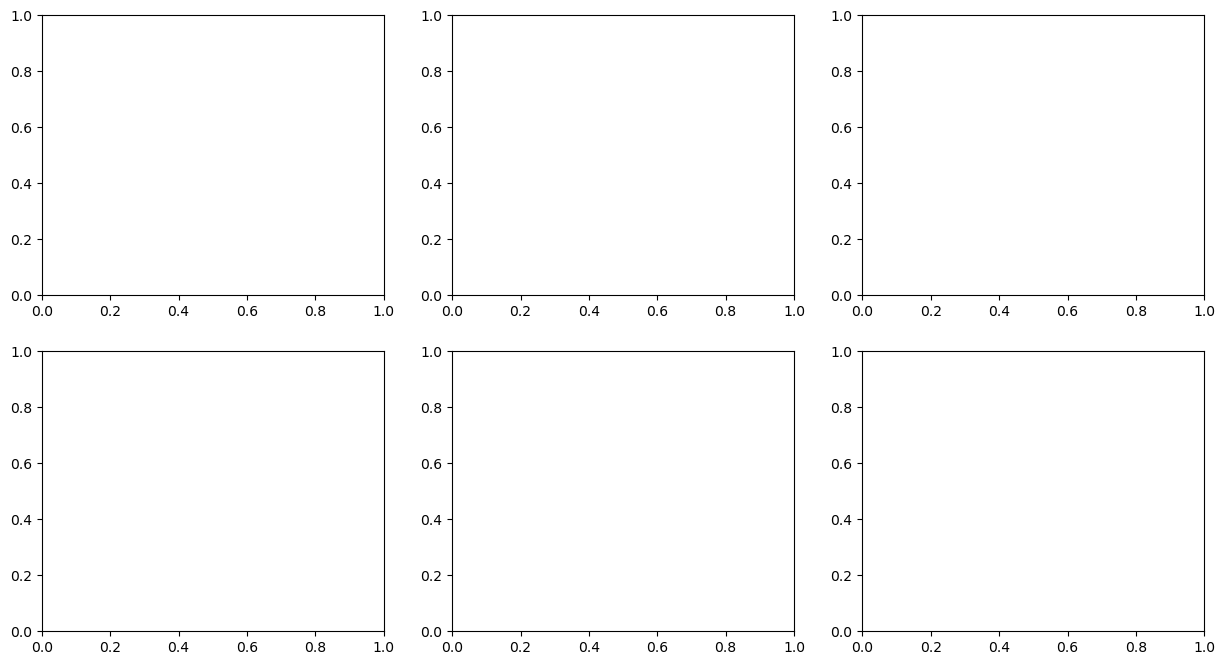

In [12]:
import matplotlib.pyplot as plt

# Retrieve one batch of images from the generator
images, labels = train_gen.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Define the class labels
class_labels = {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

# Display the first six images with their labels
fig, ax = plt.subplots(2, 3, facecolor='white', figsize=(15, 8))

for i in range(2):
    for j in range(3):
        # Calculate the index in the images and labels arrays
        idx = i * 3 + j
        
        # Get the class name from the label
        class_name = [key for key, value in class_labels.items() if value == labels[idx]][0]
        
        # Plot the image
        ax[i, j].imshow(images[idx])
        ax[i, j].set_title(f"Class: {class_name}")

plt.show()

# Convolutinal Base

In [13]:
from tensorflow.keras.metrics import Precision, Recall

# Define metrics we want to log for the compile method callback
metrics = [
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=input_shape))
cnn.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))

# Define the output 
cnn.add(Dense(4, activation='softmax'))

cnn.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 254016)            0         
                                                                 
 dense (Dense)               (None, 128)               32514176  
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 32,515,908
Trainable params: 32,515,908
Non-trainable params: 0
____________________________________________

Epoch 1/30
72/72 [==============================] - 7s 55ms/step - loss: 1.4467 - precision: 0.7052 - recall: 0.4227 - accuracy: 0.6017 - val_loss: 0.5563 - val_precision: 0.8288 - val_recall: 0.7522 - val_accuracy: 0.8010
Epoch 2/30
72/72 [==============================] - 4s 52ms/step - loss: 0.3101 - precision: 0.9019 - recall: 0.8681 - accuracy: 0.8872 - val_loss: 0.4446 - val_precision: 0.8197 - val_recall: 0.7853 - val_accuracy: 0.8098
Epoch 3/30
72/72 [==============================] - 4s 51ms/step - loss: 0.0768 - precision: 0.9847 - recall: 0.9822 - accuracy: 0.9835 - val_loss: 0.4299 - val_precision: 0.8607 - val_recall: 0.8517 - val_accuracy: 0.8551
Epoch 4/30
72/72 [==============================] - 4s 51ms/step - loss: 0.0202 - precision: 0.9974 - recall: 0.9970 - accuracy: 0.9974 - val_loss: 0.4578 - val_precision: 0.8599 - val_recall: 0.8569 - val_accuracy: 0.8604
Epoch 5/30
72/72 [==============================] - 4s 51ms/step - loss: 0.0041 - precision: 1.0000 - recall

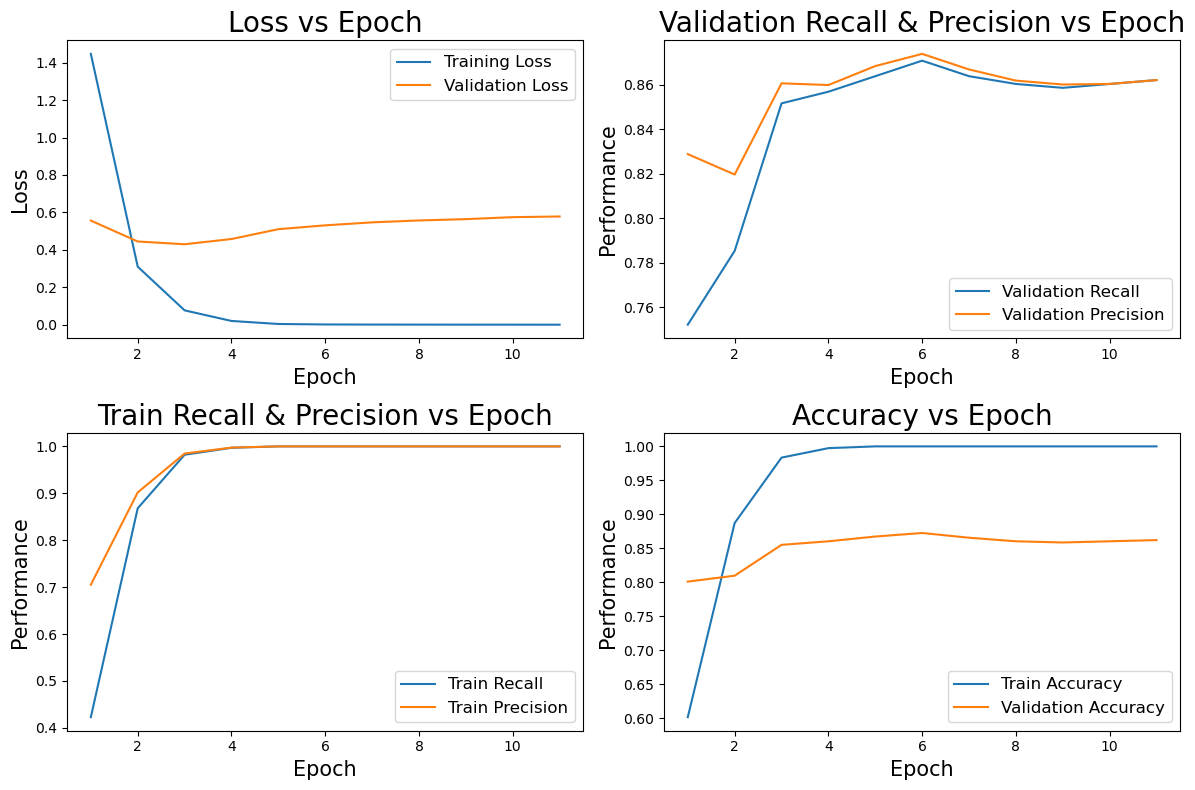

72/72 [==============================] - 3s 39ms/step - loss: 0.0248 - precision: 0.9991 - recall: 0.9991 - accuracy: 0.9991


AttributeError: 'DataFrame' object has no attribute 'append'

In [15]:
from functions import train_model, model_evaluate, view_history

conv = {}

# Train model
conv['Version1'] = train_model(cnn, train_gen, val_gen, 30)

# View history 
view_history(conv, 'Version1')

# Evalaute model
model_evaluate(cnn, train_gen, test_gen, val_gen)